# Counterfactual explanation for Mobile Price Classification dataset

TODO: explain the task and something about counterfactual explanation.

## Installation and import of the needed libraries

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

In [2]:
!mkdir my_repo
!git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo

Cloning into 'my_repo'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 54 (delta 23), reused 43 (delta 12), pack-reused 0
Unpacking objects: 100% (54/54), 11.19 KiB | 143.00 KiB/s, done.


- OMLT, version 1.1
- ONNX, version 1.12.0. A newer version is available (1.13.1) but it gives conflict error with TensorFlow. If the latter isn't needed, then the installed version can be upgraded.

Then we can install all the libraries from the ```requirements.txt``` file.

In [3]:
!pip install -r my_repo/requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.3 MB/s eta 0:00:00


In [4]:
# python modules
import configparser
import math

# 3rd party modules
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# user modules
from my_repo.utils import util_data, util_plot, util_network

In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng

SEED = 42
rng = set_default_randomness(SEED)

Moreover we import the configuration file to have all the parameters along the notebook.

In [6]:
config = configparser.ConfigParser()
config.read("my_repo/config.ini")

['my_repo/config.ini']

## Dataset exploration

For the project we use the following dataset from Kaggle: [dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification).

It gives information about different characteristics of the smartphones (e.g. RAM, cores, ...) and the target variable is the price range of the device.

In [7]:
ds_conf = config["DATASET"]
# Download the training and test datasets
util_data.download_helper(ds_conf["url_train"], ds_conf["name_train"], quiet=False)
util_data.download_helper(ds_conf["url_test"], ds_conf["name_test"], quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Q-wUd047CT_VIRsz8Sdm8k0wxS-6K2DZ
To: /content/mobile_class_train.csv
100%|██████████| 122k/122k [00:00<00:00, 58.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BfbuCmBHVryb2gExvU0A7VpEUTDxysUV
To: /content/mobile_class_test.csv
100%|██████████| 63.9k/63.9k [00:00<00:00, 13.9MB/s]


After that we downloaded the two datasets we can load them as a dataframe to leverage Pandas built-in functions.

In [19]:
df_raw = util_data.read_csv(ds_conf["name_train"])
#df_test = util_data.read_csv(ds_conf["name_test"])

At the moment we will use the 'df_train' dataset only, because the test one doesn't contain the target column, needed for counterfactual explanation.

***TODO: shouldn't we split the data before to perform the analysis? In order to check only the ones used for training***

### Preliminary exploration

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

As you can see, there are 21 columns, and they are all of type int64 or float64, therefore we don't have to deal with categorical features.

***TODO: add explanation about the features here or at the beginning*** 

We have few data (only 2000 samples) and it would be a good idea to expand the dataset with data augmentation techniques.

In [10]:
df_raw.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In the following cells we check if there are null samples or duplicates, but the dataset is already clean and we don't have these problems.

In [11]:
print(f"Number of null entries: {df_raw.isnull().sum().sum()}")

Number of null entries: 0


In [12]:
features_cols = df_raw.columns[df_raw.columns != "price_range"]

# consider only rows which have the same feature values 
df_raw[df_raw.duplicated(subset=features_cols, keep=False)].copy()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range


### Correlation between data

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.

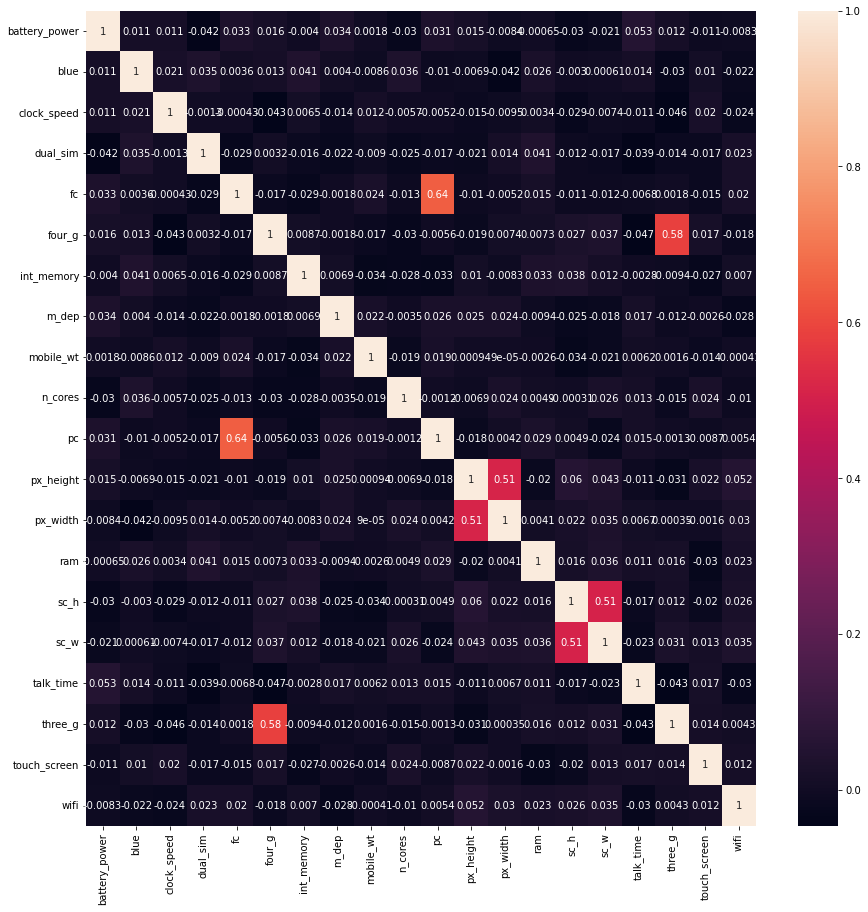

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_raw.iloc[:, df_raw.columns != "price_range"].corr(), annot=True)
# sns.heatmap(df[~any_negatives(df)].corr(), annot=True)
plt.show()

Print some information about the features to understand the range of values covered by them and other hints.

In [14]:
df_raw.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


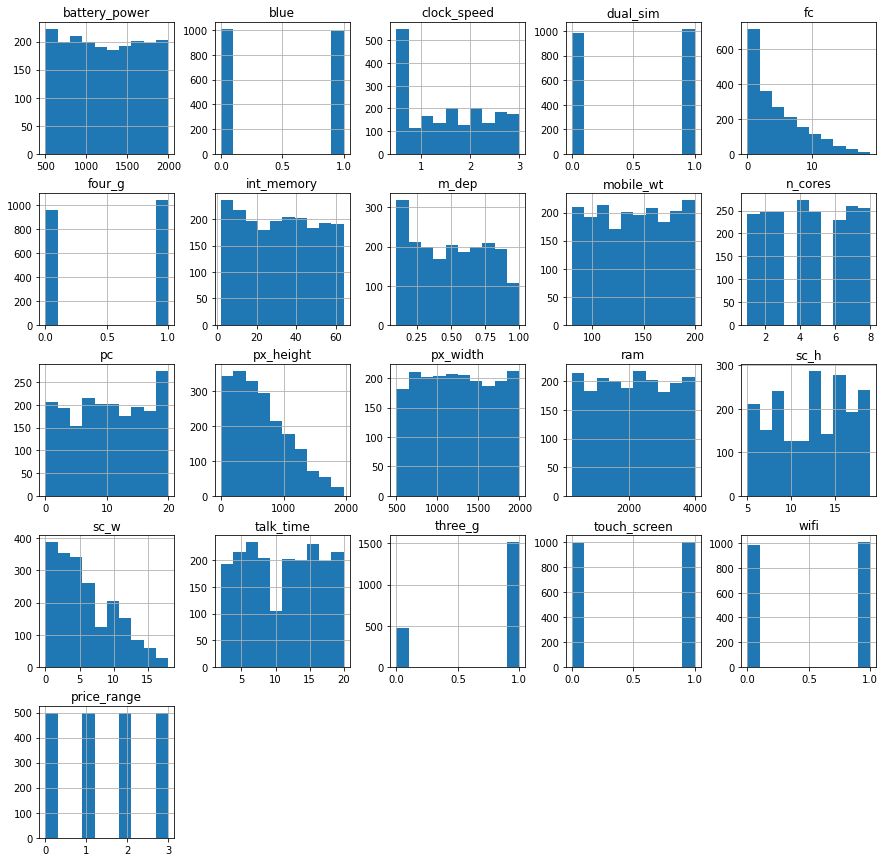

In [15]:
df_raw.hist(figsize=(15,15));

From the histograms we can see that the number of samples for each different price range is the same, therefore we don't have imbalance.

### Split the data and normalize

We decided to split the data in with a ratio of 90/10 because of the limited number of samples and we don't care much about the performance of models on the test set but we want to evaluate the counterfactuals.

In [20]:
df_train, df_test = util_data.split_train_test(df_raw, 0.1, SEED)

Before the split the different price ranges (target feature) were equally distributed, let's examine if the split has changed the distribution.

In [24]:
print("The distribution of the labels of the training set after the split:")
util_data.count_frequency_labels(df_train.price_range)

The distribution of the labels of the training set after the split:


,Frequency,Count
2,25.28%,455
3,25.17%,453
1,25.06%,451
0,24.50%,441


In [25]:
print("The distribution of the labels of the test set after the split:")
util_data.count_frequency_labels(df_test.price_range)

The distribution of the labels of the test set after the split:


,Frequency,Count
0,29.50%,59
1,24.50%,49
3,23.50%,47
2,22.50%,45


Relatively to the test set we can see that the labels are not equally likely anymore but it shouldn't affect too much our future experiments.

At this point we need to normalize our data in order to make the models work better.

In [41]:
X_train, y_train, std_scaler, label_bin = util_data.encode_normalize_df(df_train, target="price_range")
X_test, y_test, _, _ = util_data.encode_normalize_df(df_test, target="price_range", 
                                                     std_scaler=std_scaler, label_bin=label_bin)

***TODO: WIP for data augmentation***

## Models and training

We will consider different models in order to test which one works better with this dataset.